# Getting Streaming Working 

1. Sensor 1, 25 experiments
2. Welch, log normalise all 25 individual time series
3. Concatenate 5 together as "initial" time series
4. stream.update in blocks of 513 
5. (experiment with window size)
6. Visualise the cac curves afterwards (hopefully not just 1s?)

# Packages

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mat4py # .mat file conversion

from scipy.signal import welch, find_peaks, cwt # Signal Processing

import stumpy # Matrix Profile
from stumpy.floss import _cac # One sided cac

import ot # Optimal Transport

from vmdpy import VMD # Variational Mode Decomposition 

from ruptures.metrics import hausdorff # Quantifying Break Point Discrepancies

# Utils
import time
import os
loc = os.getcwd() 

# Matplotlib Params
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

os.chdir('/Users/wang_to/Documents/University/Anomaly_detection/anomalies/bookshelf/dataset')

from matplotlib import animation
from IPython.display import HTML


# Data Import and Cleaning

In [12]:
cases = [['L00','D00','V08'], ['L1C','DB0','V08'],  ['L1C','DBB','V08'], ['L13','DBB','V08']]

# Extracting relevant values (based on keys)
data = mat4py.loadmat('Building_Model.mat')
data_dict = np.load('data_dict.npy', allow_pickle=True).item()

nTests = data['nTests']
nHealthy = data['nHealthyTests']
nDamage = data['nDamagedTests']
nSensors = data['nSensors']
X = data['X']

# Making informative columns names (for pandas data frame)
info_cols = ['y_labels','damage_location','damage_level','voltage_level']
X_cols_time = ['Xt_'+str(i) for i in range(len(X[0]))]
cols = [X_cols_time + info_cols]

# Data info
signal_length = 8192   # Counts
fs = 1600 # Hz
total_time = 8192 / 1600 # 5.12 seconds
num_sensors = 24 # Total number of sensors

df_list = dict()
for sensor_num in range(1,num_sensors+1):
    sensor_str = 'Sensor'+str(sensor_num)
    df = data_dict[sensor_str]
    df_list_temp = []
    for num in cases:
        query1 = (df['damage_location']==num[0]).values
        query2 = (df['damage_level']==num[1]).values
        query3 = (df['voltage_level']==num[2]).values

        df_query = df[query1 & query2 & query3]
        df_list_temp.append(df_query.reset_index(drop=True)) # Organize cases per sensor
        
    df_list[sensor_str] = pd.concat(df_list_temp) # Concatenate cases across each sensor
    
    # Removing 40 D00 (heahlthy i.e. non damage) cases 
    # Because a lot of the damage case only have 5 events recorded in total
    # We shall have 10 D00 --> 5 DB0 --> 5 DBB --> 5 DBB cases in a sequence
    df_list[sensor_str] =  df_list[sensor_str].iloc[40:,:].reset_index(drop=True)


In [17]:
sens1 = df_list['Sensor1']
sens1_data = sens1.iloc[:,:-4]

In [18]:
sens1_data

,Xt_0,Xt_1,Xt_2,Xt_3,Xt_4,Xt_5,Xt_6,Xt_7,Xt_8,Xt_9,...,Xt_8182,Xt_8183,Xt_8184,Xt_8185,Xt_8186,Xt_8187,Xt_8188,Xt_8189,Xt_8190,Xt_8191
0,0.050964,0.097872,0.152350,-0.010274,0.019737,0.038527,-0.064753,-0.055831,-0.194660,-0.248740,...,0.000541,0.015681,-0.126940,0.149110,-0.018385,-0.029470,0.221700,-0.114910,0.040555,0.100170
1,0.050964,0.097872,0.152350,-0.010274,0.019737,0.038527,-0.064753,-0.055831,-0.194660,-0.248740,...,0.000541,0.015681,-0.126940,0.149110,-0.018385,-0.029470,0.221700,-0.114910,0.040555,0.100170
2,-0.455300,-0.629820,-0.725120,-0.505310,-0.638740,-0.698360,-0.574800,-0.455030,-0.676860,-0.168300,...,-0.052451,0.052316,0.051234,0.081245,0.254010,0.143700,0.229000,0.185740,0.027037,0.201690
3,0.201150,0.289020,0.111800,0.268880,0.191690,-0.039473,-0.044610,-0.146540,-0.081380,-0.037851,...,-0.217510,-0.322410,0.058534,-0.149650,-0.128020,0.036635,-0.225490,0.110170,0.011220,-0.181690
4,0.109360,0.141130,0.052045,0.056101,-0.011085,-0.066916,-0.100310,-0.004461,-0.170470,-0.229140,...,0.255360,0.189390,0.030551,0.224670,-0.237650,0.195200,-0.051370,-0.376210,0.109230,-0.275100
5,0.067997,0.070701,-0.106250,0.039068,-0.008516,-0.009733,0.183580,0.104900,-0.001893,0.258880,...,-0.355130,-0.344850,-0.015005,-0.312140,-0.187230,-0.025009,-0.378920,-0.039068,0.000541,-0.280100
6,-0.486120,-0.321330,-0.472060,-0.255230,-0.143430,-0.218050,-0.159920,-0.171680,-0.156950,-0.219130,...,0.208590,-0.023927,-0.169380,0.345390,-0.176140,-0.061103,0.209130,-0.190200,0.185070,0.062995
7,0.197230,0.119770,0.615080,0.348640,0.414880,0.715660,0.214400,0.493010,0.328090,0.271450,...,0.149240,0.089221,0.235760,0.124100,0.109900,0.002433,-0.256850,-0.203590,-0.276990,-0.549250
8,0.032985,0.087463,0.043664,0.205880,0.128960,0.004596,0.213590,0.017844,0.102600,-0.032309,...,-0.081110,-0.086787,-0.282670,-0.232510,-0.286180,-0.145190,-0.250090,-0.073945,-0.291590,-0.267800
9,0.238460,0.347560,0.137480,-0.163300,0.037581,-0.189530,0.118290,-0.260630,-0.208590,-0.311870,...,-0.252930,-0.040690,0.001352,0.038122,0.164250,0.135990,0.129370,0.276990,0.458810,0.329440


In [21]:
data_row_demeaned

Xt_0       0.042663
Xt_1       0.089571
Xt_2       0.144049
Xt_3      -0.018575
Xt_4       0.011436
             ...   
Xt_8187   -0.037771
Xt_8188    0.213399
Xt_8189   -0.123211
Xt_8190    0.032254
Xt_8191    0.091869
Name: 0, Length: 8192, dtype: float64

In [43]:
num_experiments = 25 
# Parameter for p-welch transform
nperseg = df_list['Sensor1'].shape[1]//8

# Total length of signal recording
signal_length = len(X_cols_time)


building_features = dict()
welch_list = []

for i in range(num_experiments):
    experiment_str = f'Experiment{i+1}'
    data_row = sens1_data.iloc[i,:]
    data_row_demeaned = data_row - np.mean(data_row) # Remove "DC" component (i.e. de-mean)
    
    pxx = welch(data_row_demeaned, fs=fs, nperseg=nperseg) # Returns len 2 tuple
    welch_list.append(np.log(pxx[1]/max(pxx[1]))) # Feature Engineering
    
    building_features[experiment_str] = np.array(welch_list)

    welch_list.clear()


In [62]:
building_seq = np.hstack([building_features[f'Experiment{i+1}'] for i in range(num_experiments)]).squeeze()

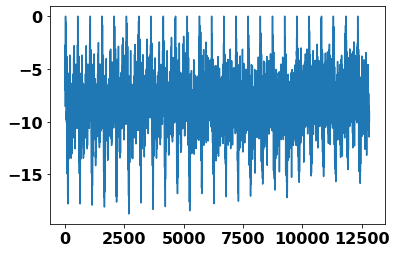

In [65]:
plt.plot(building_seq)

# Animation Code

In [74]:
m = 100
L = m 

old_data = building_seq[:513*5]
new_data = building_seq[513*5:] # take the first 5 experiments. There are 25 experiments, with changes occuring in 10, 15, 20 
mp = stumpy.stump(old_data, m=m)
cac_1d = _cac(mp[:, 3], L, bidirectional=False, excl_factor=1)  # This is for demo purposes only. Use floss() below!
stream = stumpy.floss(mp, old_data, m=m, L=L, excl_factor=1)

windows = []

for i, t in enumerate(new_data): 
    stream.update(t)
    
    if i % 100 == 0:
        windows.append((stream.T_, stream.cac_1d_))


fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_xlim((0, mp.shape[0]))
axs[0].set_ylim((-0.1, max(np.max(old_data), np.max(new_data))))
axs[1].set_xlim((0, mp.shape[0]))
axs[1].set_ylim((-0.1, 1.1))

lines = []

for ax in axs:
    line, = ax.plot([], [], lw=2)
    lines.append(line)
line, = axs[1].plot([], [], lw=2)
lines.append(line)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(window):
    data_out, cac_out = window
    for line, data in zip(lines, [data_out, cac_out, cac_1d]):
        line.set_data(np.arange(data.shape[0]), data)
    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=windows, interval=100,
                               blit=True)

anim_out = anim.to_jshtml()
plt.close()  # Prevents duplicate image from displaying
if os.path.exists("None0000000.png"):
    os.remove("None0000000.png")  # Delete rogue temp file

HTML(anim_out)


# thoughts for next time: how to interpret this streaming cac? 
- print when the changes occur 